In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [19]:
chunksize = 10000
reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)


In [30]:
df = pd.DataFrame()
for index, chunk in enumerate(reader):
        if index > 10:
            break
        df = pd.concat([df, chunk])

In [12]:
print(df.shape)
df.head(100)

(110000, 5)


,Unnamed: 0,msinstanceid,timestamp,HTTP_MCR,HTTP_RT
30000,14289203,007f243f9ac64689c594516ce6db5681f8b1693c3610fb...,38040000,0.421053,0.421053
30001,14311500,007f243f9ac64689c594516ce6db5681f8b1693c3610fb...,38100000,8.947368,8.947368
30002,14333794,007f243f9ac64689c594516ce6db5681f8b1693c3610fb...,38160000,0.428571,0.428571
30003,14356088,007f243f9ac64689c594516ce6db5681f8b1693c3610fb...,38220000,0.772727,0.772727
30004,14378366,007f243f9ac64689c594516ce6db5681f8b1693c3610fb...,38280000,0.272727,0.272727
...,...,...,...,...,...
30095,201749,007f687f46868741039d59a398b94f0860309e921d5d8e...,540000,1.847458,1.847458
30096,224218,007f687f46868741039d59a398b94f0860309e921d5d8e...,600000,2.873016,2.873016
30097,246662,007f687f46868741039d59a398b94f0860309e921d5d8e...,660000,2.129032,2.129032
30098,269109,007f687f46868741039d59a398b94f0860309e921d5d8e...,720000,1.796875,1.796875


In [34]:
# 定义步长 K
TIME_STEP = 5

def split_array_by_step(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr)-k, k)]

# 按照 msinstanceid 列分组
grouped_df = df.groupby('msinstanceid')["HTTP_RT"].apply(
    lambda x: split_array_by_step(x, TIME_STEP+1)).reset_index()


In [40]:
combined_df = pd.DataFrame()

# 对于每个分组
for index, row in grouped_df.iterrows():
    if len(row["HTTP_RT"]) > 0:
        combined_df = pd.concat([combined_df, pd.DataFrame(
            np.stack([arr for arr in row["HTTP_RT"]], axis=0))])

print(combined_df.shape)

AttributeError: 'DataFrameGroupBy' object has no attribute 'iterrows'

In [99]:
scaler = MinMaxScaler()
workload = scaler.fit_transform(combined_df)

In [100]:
# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        if data[i][time_steps-1] != 0:
            xs.append(data[i][:time_steps])
            ys.append(data[i][time_steps]/data[i][time_steps-1])
    return np.array(xs), np.array(ys)

In [101]:
x_train, y_train = create_sequences(workload, TIME_STEP)

In [102]:
x_train=np.expand_dims(x_train, axis=2)
y_train=np.expand_dims(y_train, axis=1)

print(x_train.shape)
print(y_train.shape)

(3324, 5, 1)
(3324, 1)


In [104]:
train_size = int(len(x_train) * 0.8)
val_size = len(x_train) - train_size

x_train, x_val = x_train[0:train_size, :,
                         :], x_train[train_size:len(x_train), :, :]
y_train, y_val = y_train[0:train_size], y_train[train_size:len(y_train)]


In [105]:
INPUT_DIM = 1
output_dim = 1
batch_size = 10 #每轮训练模型时，样本的数量
epochs = 50 #训练50轮次
hidden_size = 64
num_layers = 4

In [106]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [107]:
def train_model(train_x, train_y, model, epochs, batch_size, device):
    train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
    dataset = TensorDataset(train_x, train_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model


In [108]:
def predict(model, predict_x, device):
    predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(predict_x)
    return y_pred.cpu().numpy()

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTMModel(INPUT_DIM, hidden_size, num_layers, output_dim)
model.to(device)

trained_model = train_model(x_train, y_train, model,
                            epochs, batch_size, device)


Epoch 1/50, Loss: 23.8396
Epoch 2/50, Loss: 23.7885
Epoch 3/50, Loss: 23.7827
Epoch 4/50, Loss: 23.7680
Epoch 5/50, Loss: 23.7843
Epoch 6/50, Loss: 23.7567
Epoch 7/50, Loss: 23.7616
Epoch 8/50, Loss: 23.7750
Epoch 9/50, Loss: 23.7583
Epoch 10/50, Loss: 23.7637
Epoch 11/50, Loss: 23.7729
Epoch 12/50, Loss: 23.7587
Epoch 13/50, Loss: 23.7673
Epoch 14/50, Loss: 23.7643
Epoch 15/50, Loss: 23.7533
Epoch 16/50, Loss: 23.7620
Epoch 17/50, Loss: 23.7557
Epoch 18/50, Loss: 23.7723
Epoch 19/50, Loss: 23.7722
Epoch 20/50, Loss: 23.7680
Epoch 21/50, Loss: 23.7621
Epoch 22/50, Loss: 23.7663
Epoch 23/50, Loss: 23.7577
Epoch 24/50, Loss: 23.7294
Epoch 25/50, Loss: 23.7424
Epoch 26/50, Loss: 23.7430


KeyboardInterrupt: 

In [ ]:
def plot_predictions(y_val, y_pred):
    # plt.figure(figsize=(12, 6))
    plt.plot(y_val, label="Actual Values", color='blue')
    plt.plot(y_pred, label="Predicted Values", color='red')
    plt.xlabel("Timestamp")
    plt.ylabel("Workload")
    plt.legend()
    plt.show()

y_pred = predict(trained_model, x_val, device)

print(y_val,y_pred)

[[4.22782712]
 [0.        ]
 [0.81290569]
 [1.14954915]
 [1.11304285]
 [1.02985925]
 [0.95541379]] [[1.1318204]
 [1.1303885]
 [1.138173 ]
 [1.1356012]
 [1.1397035]
 [1.1342099]
 [1.1440767]]


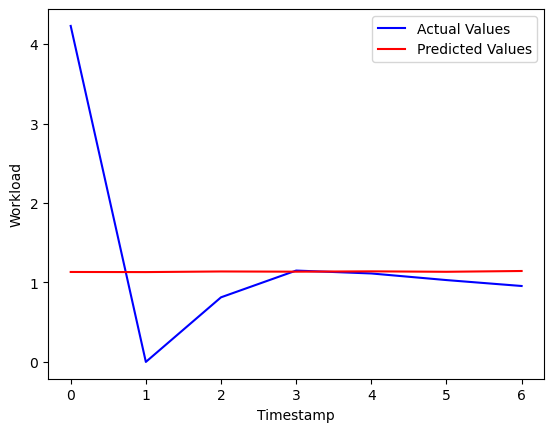

In [ ]:
plot_predictions(y_val, y_pred)
# 保存模型
torch.save(model.state_dict(), "../../model/BI-LSTM.pt")